## Damped Oscillator

In [1]:
import os, csv, sys, math
import numpy as np
from matplotlib import pyplot

## Code 
Have a look at the Euler code below. Notice all the components and how the oscillation is calculated. Linear (viscous) drag can also be understood analytically, but the Euler method allows for any sort of drag, even friction, which is highly non-linear (static/dynamic).
## Exercise
1. Change the spring constant and mass; observe the change in the signal plot
2. Change the damping; find critical damping and go beyond; notice what happens to the oscillation frequency and the time constant compared to the simple formula in the code

In [2]:
SPRING_CONSTANT = 1 # N/m
MASS = 4 # kg
DAMPING_CONSTANT = 1/10 # Ns/m

Natural Angular Frequency

$$\omega_{0} = \sqrt{\frac{k}{m}}$$

In [3]:
init_ang_freq = np.sqrt(SPRING_CONSTANT / MASS)
print("Initial Angular Frequency =", f"{init_ang_freq:.2}", "Hz")

Initial Angular Frequency = 0.5 Hz


Damped Angular Frequency

$$\omega_{damped} = \sqrt{ w_{0}^{2} - 4 \left( \frac{b}{m} \right)^{2} }$$

In [4]:
pre_sq_damp_ang_freq = init_ang_freq ** 2 - 4 * (DAMPING_CONSTANT / MASS) ** 2
if pre_sq_damp_ang_freq < 0:
    damp_ang_freq = 0.0
else:
    damp_ang_freq = np.sqrt(pre_sq_damp_ang_freq)
print("Damped Angular Frequency =", f"{damp_ang_freq:.2}", "Hz")

Damped Angular Frequency = 0.5 Hz


Quality Factor of Resonance

$$Q = \frac{m \omega_{0}}{b}$$

In [5]:
q = (MASS * init_ang_freq) / DAMPING_CONSTANT
print("Quality Factor =", f"{q:.3}")

Quality Factor = 20.0


Critical Damping Constant (fastest return to equilibrium)

$$b_{crit} = \sqrt{4mk}$$

In [6]:
b_crit = np.sqrt(4 * MASS * SPRING_CONSTANT) # Ns/m
print("Critical Damping =", f"{b_crit:.3}", "Ns/m")

Critical Damping = 4.0 Ns/m


Time Constant (only for small damping)

$$\tau = \frac{2m}{b} \text{ when } b < b_{crit}$$

In [7]:
tau = (2 * MASS) / DAMPING_CONSTANT
print("tau (only for small damping) =", f"{tau:.3}", "s")

if DAMPING_CONSTANT >= b_crit:
    print('Damping too large, ignore tau')

tau (only for small damping) = 80.0 s


Natural/Damped Frequency

$$f = \frac{\omega}{2/\pi}$$

In [8]:
init_freq = init_ang_freq / 2 / np.pi
damp_freq = damp_ang_freq / 2 / np.pi

Resonance Width
$$\Delta \omega = \frac{f_{damped}}{Q}$$

In [9]:
res_width = damp_freq / q
print("Resonance Width =", f"{res_width:.2}", "Hz")

Resonance Width = 0.004 Hz


### Euler Simulation Constants

In [10]:
ITERATIONS = 2 ** 24 # number of iterations (power of two is for the FFT below)
TIME_STEP = 0.00001 # integration time, s
INITIAL_AMPLITUDE = 1 # m
INITIAL_VELOCITY = 0 # m/s

In [11]:
time_data = np.linspace(0, ITERATIONS * TIME_STEP, ITERATIONS+1)
data_length = len(time_data)

displacement_data = np.zeros(data_length)
velocity_data = np.zeros(data_length)
acceleration_data = np.zeros(data_length)

displacement_data[0] = INITIAL_AMPLITUDE
velocity_data[0] = INITIAL_VELOCITY

### Differential Equation Sub-Calculations

**Position Equation**

$$\Delta y_{1} = \Delta y_{0} + v_{0} \delta t + \frac{1}{2} a_{0} \delta t^{2}$$

In [12]:
def calculate_position_from_eq(prev_position, velocity, accel, time_step):
    return prev_position + velocity * time_step + (1/2) * accel * (time_step ** 2) 

**Acceleration Calculation** (linear spring, viscous drag)

$$\vec{a}_{0}(k, \Delta y_{i-1}, m,) = \frac{-k \Delta y_{i-1}}{m}$$
$$\vec{a}_{i}(k, \Delta y_{i-1}, m, b, v_{i-1}) = \frac{-k \Delta y_{i-1} - b v_{i-1}}{m}$$

In [13]:
def calculate_acceleration(k, m, b, prev_displacement, prev_velocity):
    return (-k * prev_displacement - b * prev_velocity)/m

In [14]:
acceleration_data[0] = -SPRING_CONSTANT * displacement_data[0] / MASS
displacement_data[1] = calculate_position_from_eq(displacement_data[0], velocity_data[0], 
                                                  acceleration_data[0], TIME_STEP)

**Sub-Differential Update Function** (for Euler's method)

$$A_{i} = A_{i-1} + \frac{dA}{dt}_{i-1} \delta t$$

where $A$ is just any variable that is not the highest-order in the differential equation

In [15]:
def calculate_differential_update(previous, higher_order, time_step):
    return previous + higher_order * time_step

**Envelope Function**

$$y(t) = \pm y_{0} e^{-t/\tau} \text{ when } b < b_{crit}$$

In [16]:
def calculate_envelope(y0, t, tau):
    return y0 * np.exp(-t/(tau))

### Euler Simulation

In [17]:
i = 2
while i < ITERATIONS + 1:
    acceleration_data[i] = calculate_acceleration(SPRING_CONSTANT, MASS, DAMPING_CONSTANT, displacement_data[i-1], velocity_data[i-1])
    velocity_data[i]     = calculate_differential_update(velocity_data[i-1], acceleration_data[i-1], TIME_STEP)
    displacement_data[i] = calculate_differential_update(displacement_data[i-1], velocity_data[i-1], TIME_STEP)
    i += 1

In [18]:
# Truncate the arrays
time_data         = time_data[0:i-1]
displacement_data = displacement_data[0:i-1]
velocity_data     = velocity_data[0:i-1]
acceleration_data = acceleration_data[0:i-1]

### Plotting

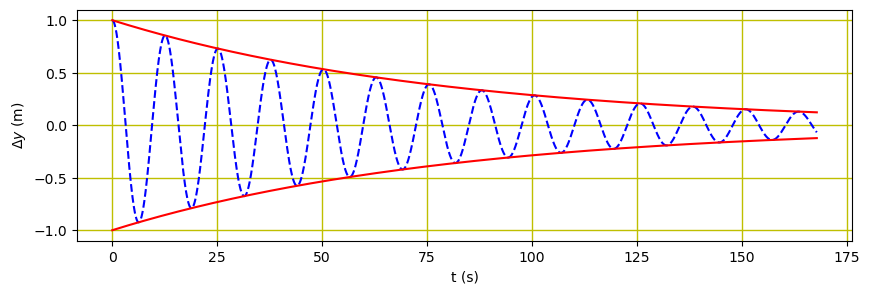

In [19]:
pyplot.figure(figsize=(10,3))
pyplot.plot(time_data, displacement_data, "--",color = 'b')
pyplot.xlabel("t (s)")
pyplot.ylabel("$\Delta y$ (m)")
pyplot.ylim(-1.1 * INITIAL_AMPLITUDE, 
            1.1 * INITIAL_AMPLITUDE)
if DAMPING_CONSTANT < b_crit:
    # tau is small, so we can print the envelope (as it will oscillate)
    abs_y_envelope_values = calculate_envelope(INITIAL_AMPLITUDE, time_data, tau)
    pos_y_envelope_values = abs_y_envelope_values
    neg_y_envelope_values = -abs_y_envelope_values
    
    # plot
    pyplot.plot(time_data, pos_y_envelope_values, color="red")
    pyplot.plot(time_data, neg_y_envelope_values, color="red")
    
pyplot.grid(color='y', linestyle='-', linewidth=1)   
pyplot.show()